# Model V1

In [1]:
import os
import pathlib
import tensorflow as tf
import pandas as pd
from dotenv import load_dotenv
import wandb

from bcd.model.factory import V1ModelFactory
from bcd.model.project import Project
from bcd.model.repo import ModelRepo
pd.set_option('display.max_rows',999)
load_dotenv()

True

## Configuration

In [2]:
# Experiment Parameters
%env "WANDB_NOTEBOOK_NAME" "01_model_V1.ipynb"
full_dataset = False
project = "BCD_V1_CBIS-DDSM" if full_dataset else "BCD_V1_CBIS-DDSM-10" 

# Model Parameters
force = True  # Whether to retrain if the model and weights already exist from a prior training session.
metrics = ['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
loss = "binary_crossentropy"
activation = "sigmoid"
epochs = 100
learning_rate = 1e-4
num_classes = 2

# Dataset params
dataset = "CBIS-DDSM" if full_dataset else "CBIS-DDSM-10"
batch_size = 64 if full_dataset else 32
input_shape = (224,224,3)
output_shape = 1
train_dir = pathlib.Path("data/image/1_final/training/training/").with_suffix('') if full_dataset else pathlib.Path("data/image/1_final/training_10/training/").with_suffix('') 

# Early stop parameters 
es_min_delta = 0.0001
es_monitor = "val_loss"  # Monitor validation loss for early stopping
es_patience = 10  # The number of epochs for which lack of improvement is tolerated 
es_restore_best_weights = True  # Returns the best weights rather than the weights at the last epoch.
es_verbose = 1

# Reduce LR on Plateau Parameters
rlr_monitor = "val_loss"
rlr_factor = 0.5
rlr_patience = 3
rlr_verbose = 1
rlr_mode = "auto"
rlr_min_delta = 1e-4
rlr_min_lr=1e-10



env: "WANDB_NOTEBOOK_NAME"="01_model_V1.ipynb"


## Experiment Config

In [3]:
config = {
    "project": project,        
    "dataset": dataset,
    "run_name": None,    
    "num_classes": num_classes,
    "batch_size": batch_size,
    "epochs": epochs,    
    "learning_rate": learning_rate,
    "loss": loss,    
    "early_stop_min_delta": es_min_delta,
    "early_stop_monitor": es_monitor,
    "early_stop_patience": es_patience,
    "early_stop_restore_best_weights": es_restore_best_weights,
    "early_stop_verbose": es_verbose,
    "rlr_monitor": rlr_monitor,
    "rlr_factor": rlr_factor,
    "rlr_patience": rlr_patience,
    "rlr_verbose": rlr_verbose,
    "rlr_mode": rlr_mode,
    "rlr_min_delta": rlr_min_delta,
    "rlr_min_lr": rlr_min_lr
    
}

## Load Data

In [4]:
# Training DataSet (10%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Validation DataSet (10%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

Found 276 files belonging to 2 classes.
Using 221 files for training.
Found 276 files belonging to 2 classes.
Using 55 files for validation.


## Model Selection

In [5]:
factory = V1ModelFactory(input_shape=input_shape, output_shape=output_shape, activation=activation)

## Callbacks

In [6]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor=es_monitor, 
                                                       min_delta=es_min_delta,
                                                       patience=es_patience, 
                                                       restore_best_weights=es_restore_best_weights,
                                                       verbose=es_verbose)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor=rlr_monitor,
                                                          factor=rlr_factor,
                                                          patience=rlr_patience,
                                                          verbose=rlr_verbose,
                                                          mode=rlr_mode,
                                                          min_delta=rlr_min_delta,
                                                          min_lr=rlr_min_lr)
callbacks = [early_stop_callback, reduce_lr_callback]

## Dependencies

In [7]:
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
repo = ModelRepo()

## Project
Instantiate and run the project.

""


              precision    recall  f1-score   support

      benign       0.69      0.92      0.79        38
   malignant       0.25      0.06      0.10        17

    accuracy                           0.65        55
   macro avg       0.47      0.49      0.44        55
weighted avg       0.55      0.65      0.57        55



Model InceptionResNet_V1-CBIS-DDSM-10 does not exist.
Traceback (most recent call last):
  File "/home/john/projects/bcd/bcd/model/repo.py", line 43, in get
    model = tf.keras.models.load_model(filepath)
  File "/home/john/anaconda3/envs/bcd/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/john/anaconda3/envs/bcd/lib/python3.10/site-packages/keras/saving/save.py", line 204, in load_model
    raise IOError(f'No file or directory found at {filepath_str}')
OSError: No file or directory found at models/InceptionResNet_V1-CBIS-DDSM-10.keras


FileNotFoundError: 

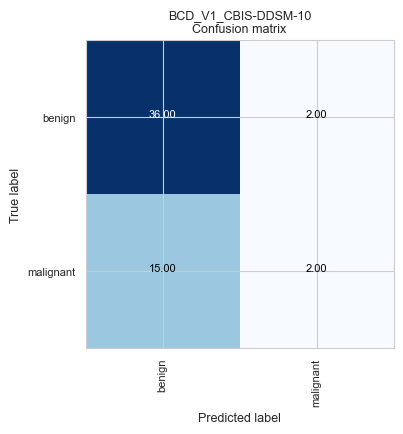

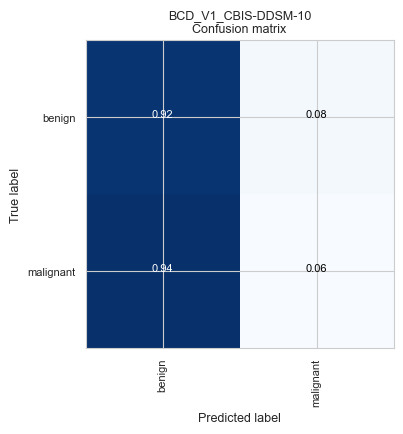

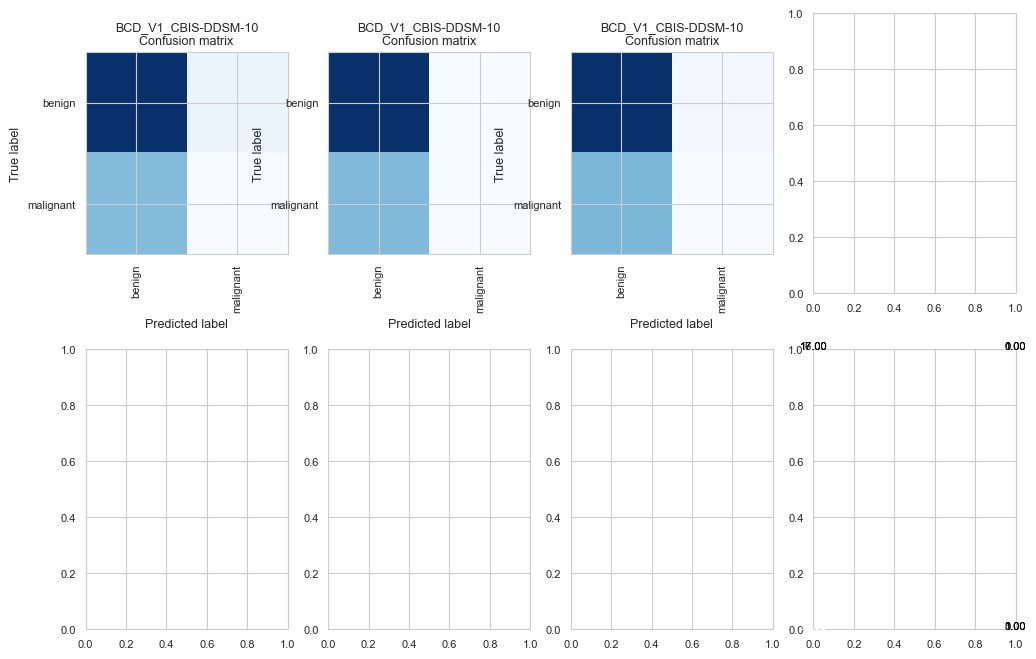

In [8]:
name = "DenseNet"
project = Project(name=config['project'], 
                  config=config, 
                  factory=factory, 
                  train_ds=train_ds, 
                  val_ds=val_ds, 
                  repo=repo, 
                  optimizer=optimizer, 
                  callbacks=callbacks, 
                  metrics=metrics, 
                  force=force)
#project.run_experiment(name=name)
project.log
project.classification_report(name=name)
project.plot_confusion_matrix(name=name)
project.plot_confusion_matrix(name=name, normalize=True)
project.plot_confusion_matrices()
project.plot_learning_curve(name=name)
project.plot_validation_curve(name=name)
project.plot_performance_curves(name=name)
project.summarize_run(name=name)